In [1]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
%cd /home/jx8fh/Projects/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# USE GPU 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data_fnames = [f'debug/notebooks/2024-11-20-debug-sona-data/LV_mask_slice{idx}.npy' for idx in range(3)]
test_data = []
for datum_fname in data_fnames:
    test_data.append({
        'myo_masks': np.load(datum_fname, allow_pickle=True)
    })

for datum_idx in range(len(test_data)):
    test_data[datum_idx]['ori_n_frames'] = test_data[datum_idx]['myo_masks'].shape[-1]

In [5]:
# data[0].shape

In [6]:
# test_fname = '/scratch/jx8fh/2024-06-22-MICCAI-ShapeMI-Workshop-data/lamod_test.npy'
# test_data = np.load(test_fname, allow_pickle=True).tolist()

In [7]:
import json
config_fname = 'configs/ours-LaMoD.json'
config = json.load(open(config_fname))

In [8]:
from models.LaMoD import LaMoD
network = LaMoD(config['networks'], device).to(device)

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': True, 'pretrained_model_path': 'checkpoints/ours_motion_regression.pth'}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
Loading pretrained model from checkpoints/ours_motion_regression.pth


In [23]:
from skimage.transform import resize
from skimage.morphology import dilation, disk, closing
check_data_idx = 0
inference_mask_raw = torch.from_numpy(
    resize(test_data[check_data_idx]['myo_masks'][...,0]>0.5, [48,48], anti_aliasing=False)
)
inference_mask = torch.from_numpy(dilation(inference_mask_raw, disk(2)))

In [24]:
# inference_mask.shape

In [25]:
test_data[check_data_idx]['myo_masks'].shape

(128, 128, 32)

In [42]:
# check_data_idx = 1

# Prepare Pytorch tensor
inference_input_video      = torch.from_numpy(test_data[check_data_idx]['myo_masks']).to(device).moveaxis(-1,0)[None, None]
inference_input_video_ori_frame = test_data[check_data_idx]['ori_n_frames']
inference_output_dict = network.inference(
    inference_input_video, 
    ori_n_frames=[inference_input_video_ori_frame],
    skip_diffusion=False)[0]

# Extract prediction
inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73

In [43]:
inference_input_video.shape

torch.Size([1, 1, 32, 128, 128])

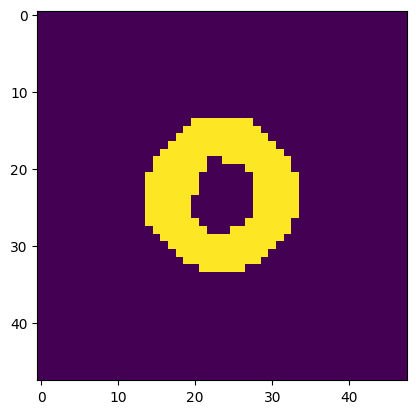

In [44]:
plt.imshow(inference_mask)

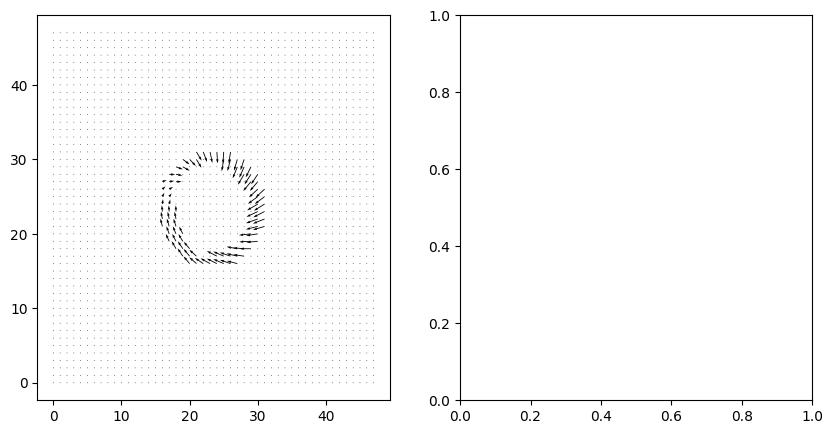

In [45]:
# Visualize 
check_frame_idx = 20
fig, axs = plt.subplots(1, 2, figsize=(10,5))
# Prediction
axs[0].quiver(
    inference_disp[0,0,check_frame_idx]*inference_mask_raw,
    inference_disp[0,1,check_frame_idx]*inference_mask_raw,
    units='xy',
    scale=1
)
# DENSE GT
# axs[1].quiver(
#     test_data[check_data_idx]['DENSE_disp'][0,check_frame_idx],
#     test_data[check_data_idx]['DENSE_disp'][1,check_frame_idx],
#     units='xy',
#     scale=1
# )

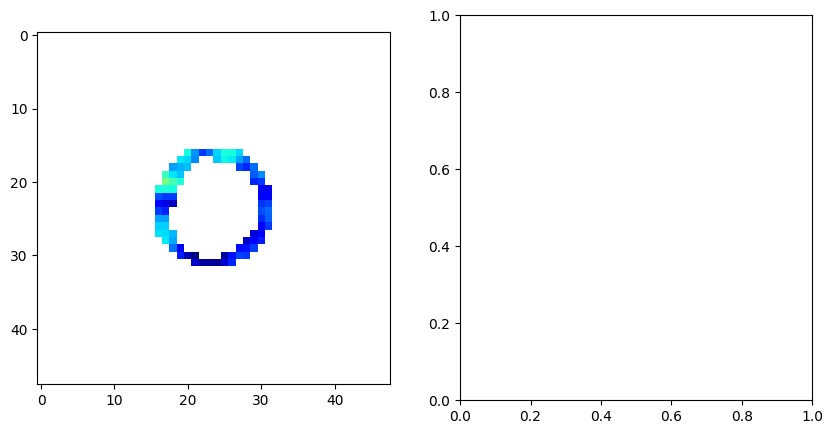

In [46]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain

H, W = inference_disp.shape[-2:]
X, Y = np.meshgrid(np.arange(W), np.arange(H))
dXt = np.moveaxis(inference_disp[0,0].numpy(), 0, -1)
dYt = np.moveaxis(inference_disp[0,1].numpy(), 0, -1)
mask = inference_mask.numpy()
Nfr = inference_disp.shape[2]
strain = pixelstrain(
    X=X, Y=Y, 
    dXt=dXt, dYt=dYt, 
    mask=mask, times=np.arange(Nfr))
strainCC = strain['CC']
for frame_idx in range(strainCC.shape[-1]):
    strainCC[...,frame_idx][inference_mask_raw<0.5] = np.nan
# mask_GT = (np.abs(test_data[check_data_idx]['DENSE_disp'][0][0]) + np.abs(test_data[check_data_idx]['DENSE_disp'][1][0])) > 0
# strain_GT = pixelstrain(
#     X=X, Y=Y, 
#     dXt=np.moveaxis(test_data[check_data_idx]['DENSE_disp'][0], 0, -1), 
#     dYt=np.moveaxis(test_data[check_data_idx]['DENSE_disp'][1], 0, -1), 
#     mask=mask_GT, times=np.arange(Nfr))
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(strainCC[...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)
# axs[1].imshow(strain_GT['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)

Text(0, 0.5, 'Count')

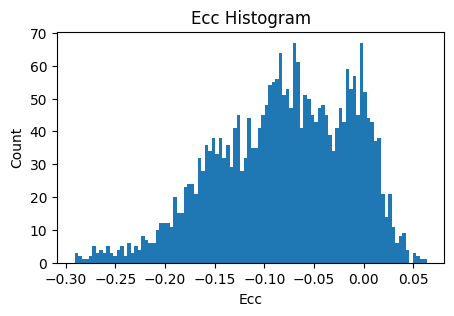

In [47]:
fig, axe = plt.subplots(1, 1, figsize=(5, 3))
axe.hist(np.reshape(strain['CC'], (-1, 1)), bins=100)
axe.set_title('Ecc Histogram')
axe.set_xlabel('Ecc')
axe.set_ylabel('Count')

In [48]:
inference_disp[0].moveaxis(1,-1).numpy().shape

(2, 48, 48, 31)

In [49]:
from modules.data.processing.strain_analysis.resample_strain_matrix import resample_strain_matrix_2d
from modules.data.processing.strain_analysis.six_segments_core import six_segments_core, get_various_segmental_strain_data

cine_origin = np.array([24,24])
cine_insertion = np.array([24,0])

cine_strain_imgs = strain['CC']
cine_strain_mask = inference_mask_raw.numpy()
cine_segmental_strain = get_various_segmental_strain_data(
    cine_strain_imgs, 
    cine_strain_mask, 
    cine_origin, 
    cine_insertion,
    enable_offset=True,
    offset_degrees=[90, 120, 120],
    generate_layerid_map=False)

In [50]:
check_dict(cine_segmental_strain)

origin                                                       (2,)                
insertion                                                    (2,)                
CCs4                                                         (4, 31)             
CCs6                                                         (6, 31)             
CCs18                                                        (18, 31)            
Seg4                                                         dict_keys(['insertion_shifted', 'BasisNames', 'BasisID', 'SegmentID'])
Seg6                                                         dict_keys(['insertion_shifted', 'BasisNames', 'BasisID', 'SegmentID'])
Seg18                                                        dict_keys(['insertion_shifted', 'BasisNames', 'BasisID', 'SegmentID'])


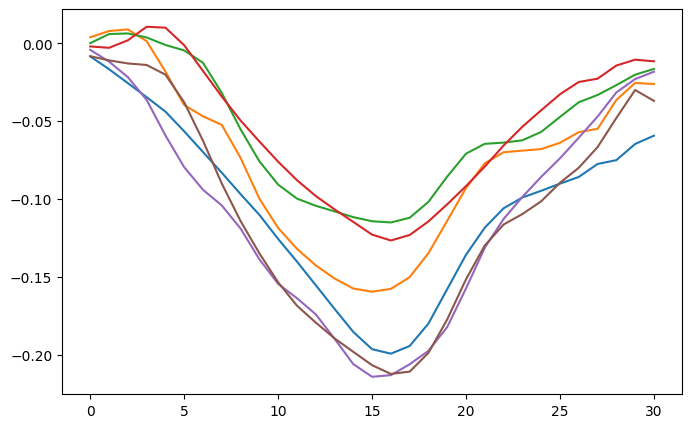

In [51]:
fig, axe = plt.subplots(1, 1, figsize=(8, 5))
for sector_idx in range(6):
    axe.plot(cine_segmental_strain['CCs6'][sector_idx])